# Apple Leaf Disease Detection

## Dataset - https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset/data

## Importing libraries and reading dataset

In [2]:
import cv2
import os
import numpy as np
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

data_path = '../dataset/apple/'
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))  
print(label_dict)
print(categories)
print(labels)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3}
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']
[0, 1, 2, 3]


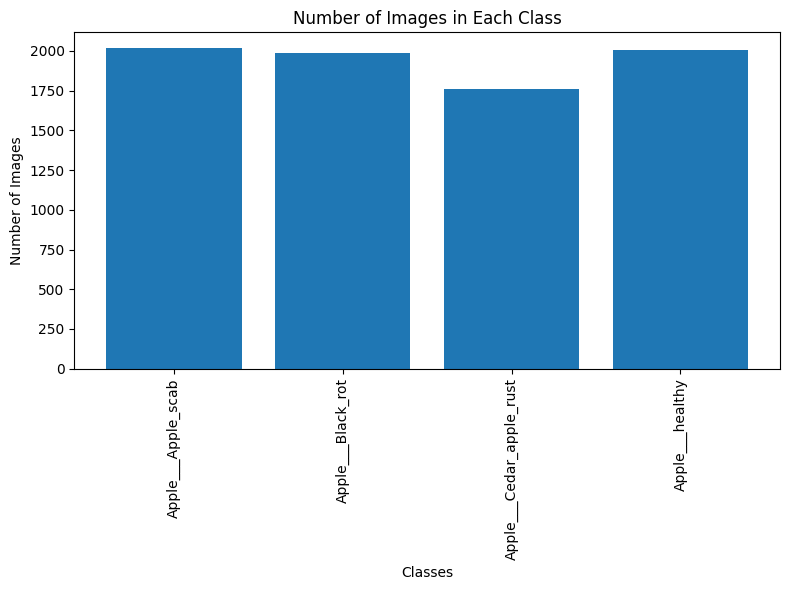

In [3]:
import os
import matplotlib.pyplot as plt

class_counts = {}

for category in categories:
    class_path = os.path.join(data_path, category)
    num_images = len(os.listdir(class_path))
    class_counts[category] = num_images

plt.figure(figsize=(8, 6))  # Increase the figure width
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Number of Images in Each Class')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)  # Increase rotation angle for better alignment
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## Resizing and converting images into greyscale

In [4]:
from tqdm import tqdm

img_size = 224
data = []
label = []

# Wrap the outer loop with tqdm for progress tracking
for category in tqdm(categories, desc="Processing categories"):
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (img_size, img_size))
            # resizing the image into 224x224, as required by ResNet50
            data.append(resized)
            label.append(label_dict[category])
            # appending the image and the label(categorized) into the list (dataset)
        except Exception as e:
            print('Exception:', e)
            # if any exception raised, the exception will be printed here. And pass to the next image

Processing categories: 100%|█████████████████████████████████████████████████████████████| 4/4 [00:22<00:00,  5.56s/it]


In [5]:
data = np.array(data) / 255.0
data = np.stack((data,) * 3, axis=-1)  # stack grayscale images to create 3 channels
label = np.array(label)
new_label = to_categorical(label)

In [6]:
data.shape

(7771, 224, 224, 3)

## Splitting dataset into testing and training

In [7]:
x_train, x_test, y_train, y_test = train_test_split(data, new_label, test_size=0.2, random_state=42)

## VGG16

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16

img_size = 224

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers in the base VGG16 model
for layer in base_model.layers:
    layer.trainable = False

# Create the model architecture
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(len(categories), activation='softmax')(x)

# Define the input and output of the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# Define a function to schedule the learning rate
def lr_schedule(epoch):
    """
    Returns a custom learning rate that decreases as the epochs progress.
    """
    learning_rate = 0.001  # Initial learning rate
    
    if epoch > 5:
        learning_rate *= 0.1  # Decrease learning rate after 5 epochs
    if epoch > 10:
        learning_rate *= 0.1  # Further decrease after 10 epochs
    
    return learning_rate

# Define learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)
    
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Define model checkpoint callback to save the best model during training
checkpoint = ModelCheckpoint("../models/apple.keras", monitor='val_loss', save_best_only=True)

# Train the model with early stopping and model checkpoint callbacks
history_vgg = model.fit(x_train, y_train, 
                        batch_size=32, 
                        epochs=15, 
                        validation_data=(x_val, y_val),
                        callbacks=[lr_scheduler, early_stopping, checkpoint])

Epoch 1/15
156/156 [==============================] - 60s 239ms/step - loss: 0.6047 - accuracy: 0.7639 - val_loss: 0.1695 - val_accuracy: 0.9453 - lr: 0.0010
Epoch 2/15
156/156 [==============================] - 27s 173ms/step - loss: 0.2714 - accuracy: 0.9035 - val_loss: 0.1296 - val_accuracy: 0.9582 - lr: 0.0010
Epoch 3/15
156/156 [==============================] - 27s 173ms/step - loss: 0.1911 - accuracy: 0.9326 - val_loss: 0.0970 - val_accuracy: 0.9686 - lr: 0.0010
Epoch 4/15
156/156 [==============================] - 27s 174ms/step - loss: 0.1702 - accuracy: 0.9358 - val_loss: 0.0903 - val_accuracy: 0.9662 - lr: 0.0010
Epoch 5/15
156/156 [==============================] - 27s 174ms/step - loss: 0.1416 - accuracy: 0.9471 - val_loss: 0.0799 - val_accuracy: 0.9727 - lr: 0.0010
Epoch 6/15
156/156 [==============================] - 27s 171ms/step - loss: 0.1206 - accuracy: 0.9529 - val_loss: 0.0873 - val_accuracy: 0.9662 - lr: 0.0010
Epoch 7/15
156/156 [==============================] 

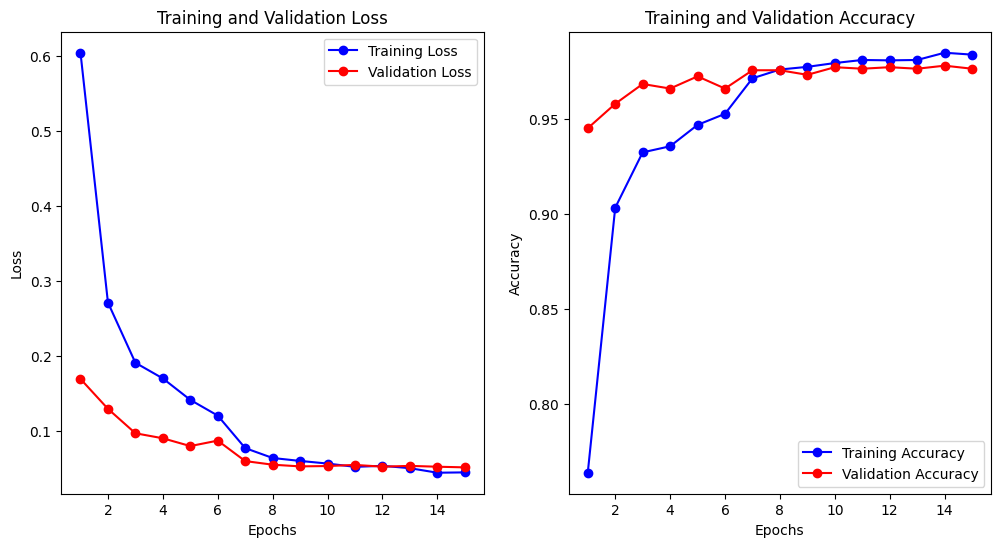

In [12]:
# Learning Curve
train_loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
train_accuracy = history_vgg.history['accuracy']
val_accuracy = history_vgg.history['val_accuracy'] 
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [3]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

img_size = 224

# Load the pre-trained model
loaded_model = load_model('../models/apple.keras')
categories = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']


label_dict = {i: category for i, category in enumerate(categories)}

# Read the input image (grayscale)
img = cv2.imread('../banana.jpg', cv2.IMREAD_GRAYSCALE)

# Convert grayscale image to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

# Resize the image to img_size x img_size
resized_img = cv2.resize(img_rgb, (img_size, img_size))

# Normalize pixel values to range [0, 1]
normalized_img = resized_img / 255.0

# Reshape input for model prediction
input_img = normalized_img.reshape(-1, img_size, img_size, 3)  # Reshape input for model prediction

# Make a prediction
prediction = loaded_model.predict(input_img)

# Get the predicted class label
predicted_class_index = np.argmax(prediction)
predicted_label = label_dict[predicted_class_index]

print(predicted_label)

1/1 [==============================] - 0s 183ms/step
Apple___Apple_scab


In [15]:
# Load the best model
# Load the pre-trained model
loaded_model = load_model('../models/apple.keras')
categories = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']

# Define the categories dictionary if not defined already
label_dict = {v: k for k, v in label_dict.items()}

# Define confidence threshold
confidence_threshold = 0.5

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    # Read the input image (grayscale)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    # Convert grayscale image to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Resize the image to target size
    resized_img = cv2.resize(img_rgb, target_size)
    # Normalize pixel values to range [0, 1]
    normalized_img = resized_img / 255.0
    # Reshape input for model prediction
    input_img = normalized_img.reshape(-1, target_size[0], target_size[1], 3)
    return input_img

def predict_with_threshold(model, img_path, class_names, threshold=0.5):
    input_img = load_and_preprocess_image(img_path)
    predictions = model.predict(input_img)
    print(predictions)
    predicted_class = np.argmax(predictions)
    confidence = np.max(predictions)

    if confidence < threshold:
        print("No class found")
    else:
        return class_names[predicted_class], confidence

# Example usage
img_path = '../banana.jpg'
predicted_label, confidence = predict_with_threshold(loaded_model, img_path, label_dict, confidence_threshold)
print(f'The model predicts the image is: {predicted_label} with confidence {confidence}')

1/1 [==============================] - 0s 132ms/step
[[9.9122554e-01 2.4815315e-06 1.7812481e-09 8.7719690e-03]]
The model predicts the image is: Apple___Apple_scab with confidence 0.99122554063797
